Message 1: [0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0]
Message 2: [0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1]
Message 3: [0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1]
Message 4: [1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0]

After Watermark 1:
--------------------------------------------------
  SNR: 37.63 dB
  Watermark 1: BER=0.38, Prob=0.25

After Watermark 2:
--------------------------------------------------
  SNR: 32.96 dB
  Watermark 1: BER=0.38, Prob=1.00
  Watermark 2: BER=0.56, Prob=1.00

After Watermark 3:
--------------------------------------------------
  SNR: 30.60 dB
  Watermark 1: BER=0.50, Prob=1.00
  Watermark 2: BER=0.56, Prob=1.00
  Watermark 3: BER=0.50, Prob=1.00

After Watermark 4:
--------------------------------------------------
  SNR: 29.01 dB
  Watermark 1: BER=0.50, Prob=1.00
  Watermark 2: BER=0.56, Prob=1.00
  Watermark 3: BER=0.50, Prob=1.00
  Watermark 4: BER=0.38, Prob=1.00


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

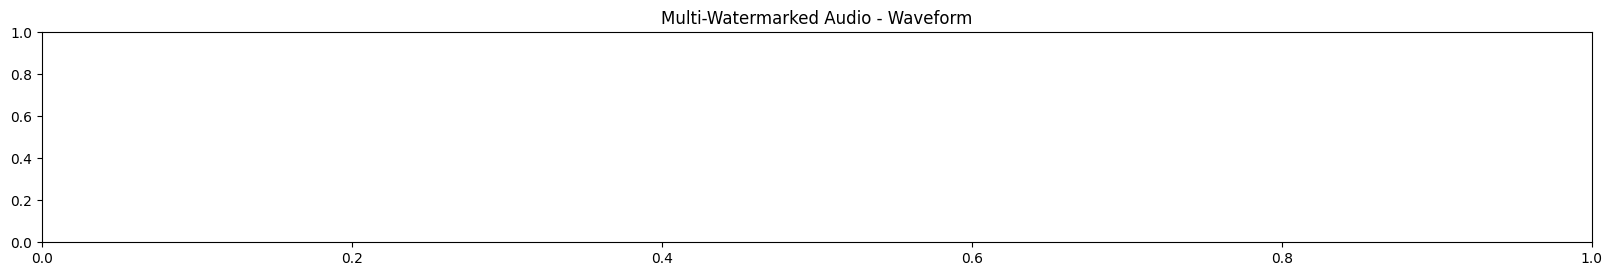

In [1]:
import torch
import torchaudio
import urllib
import os
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def download_sample_audio():
    url = "file:///C:/Users/x/Downloads/LJ025-0076.wav"
    with open("test.wav", "wb") as f:
        resp = urllib.request.urlopen(url)
        f.write(resp.read())
    
    wav, sample_rate = torchaudio.load("test.wav")
    return wav, sample_rate

def plot_waveform_and_specgram(audio, sr, title):
    plt.figure(figsize=(20,6))
    plt.subplot(2,1,1)
    plt.title(f"{title} - Waveform")
    plt.plot(audio.numpy()[0])
    plt.subplot(2,1,2)
    plt.title(f"{title} - Spectrogram")
    plt.specgram(audio.numpy()[0], Fs=sr)
    plt.tight_layout()
    plt.show()

def play_audio(audio, sr):
    # Placeholder for audio playback (implement as needed)
    print(f"Audio shape: {audio.shape}, Sample Rate: {sr}")

# Import AudioSeal
from audioseal import AudioSeal

def main():
    # Load audio
    audio, original_sr = download_sample_audio()
    
    # Resample to 16kHz if necessary
    sr = 16000
    if original_sr != sr:
        resampler = torchaudio.transforms.Resample(orig_freq=original_sr, new_freq=sr)
        audio = resampler(audio)
    
    # Trim or pad audio to 8 seconds
    target_length = sr * 8  # 8 seconds
    if audio.shape[1] > target_length:
        audio = audio[:, :target_length]
    elif audio.shape[1] < target_length:
        padding = torch.zeros(audio.shape[0], target_length - audio.shape[1])
        audio = torch.cat([audio, padding], dim=1)
    
    # Load models
    generator = AudioSeal.load_generator("audioseal_wm_16bits")
    detector = AudioSeal.load_detector("audioseal_detector_16bits")
    
    # Generate 4 UNIQUE messages (16-bit)
    messages = [torch.randint(0, 2, (1, 16)) for _ in range(4)]
    
    # Print original messages
    for i, msg in enumerate(messages):
        print(f"Message {i+1}: {msg.numpy().flatten()}")
    
    # Prepare audio (add batch and potentially channel dimension)
    audios = audio.unsqueeze(0)  # Add batch dimension
    
    # Initialize watermarked audio
    watermarked_audio = audios.clone()
    
    # Embed watermarks cumulatively
    for idx, msg in enumerate(messages):
        # Apply watermark
        watermarked_audio = generator(watermarked_audio, 
                                      sample_rate=sr, 
                                      alpha=0.3)  # Reduced alpha for multiple embeddings
        
        # Calculate metrics
        noise = watermarked_audio - audios
        snr = 10 * torch.log10(audios.pow(2).mean() / noise.pow(2).mean())
        
        print(f"\nAfter Watermark {idx+1}:")
        print("-" * 50)
        print(f"  SNR: {snr:.2f} dB")
        
        # Detect ALL previous watermarks
        for detect_idx in range(idx+1):
            detector.message = messages[detect_idx]
            prob, detected_msg = detector.detect_watermark(
                watermarked_audio, 
                sample_rate=sr, 
                message_threshold=0.7  # Increased threshold
            )
            ber = (messages[detect_idx] != detected_msg.round()).float().mean()
            print(f"  Watermark {detect_idx+1}: BER={ber:.2f}, Prob={prob:.2f}")
    
    # Visualize
    plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, title="Multi-Watermarked Audio")
    play_audio(watermarked_audio, sr)
    
    print(f"Final watermarked audio shape: {watermarked_audio.shape}")

if __name__ == "__main__":
    main()